**In this notebook we use PyCaret to quickly compare the efficacy CML models to predict cloud cover**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import xarray as xr

Open the data

In [2]:
# define a function that opens the data file and returns the data
def open_data(data_dir):
    # open the data file
    era5 = xr.open_dataset(data_dir+'era5_data.nc')
    era5_single_lvl = xr.open_dataset(data_dir+'era5_single_levels.nc')
    goes_cod = xr.open_dataset(data_dir+'GOESDataUpdated/CloudOpticalDepth_remapped.nc')
    goes_ctt = xr.open_dataset(data_dir+'GOESDataUpdated/CloudTopTemperature_remapped.nc')
    goes_dsw = xr.open_dataset(data_dir+'GOESDataUpdated/DownwardSW_remapped.nc')
    goes_rsw = xr.open_dataset(data_dir+'GOESDataUpdated/ReflectedSW_remapped.nc')
    goes_tpw = xr.open_dataset(data_dir+'GOESDataUpdated/TotalPrecipWater_remapped.nc')
    # return the dataframes
    return era5, era5_single_lvl, goes_cod, goes_ctt, goes_dsw, goes_rsw, goes_tpw

In [3]:
# SET YOU OWN DATA DIRECTORY HERE
data_dir = '/Users/ionph/MLdata/'
# call the function to open the data
era5, era5_single_lvl, goes_cod, goes_ctt, goes_dsw, goes_rsw, goes_tpw = open_data(data_dir)

In [4]:
era5

<xarray.Dataset>
Dimensions:         (valid_time: 1650, pressure_level: 2, latitude: 41,
                     longitude: 81)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2014-04-01T13:00:00 ... 2024-...
  * pressure_level  (pressure_level) float64 950.0 700.0
  * latitude        (latitude) float64 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude       (longitude) float64 -65.0 -64.75 -64.5 ... -45.25 -45.0
Data variables:
    number          int64 ...
    expver          (valid_time) object ...
    cc              (valid_time, pressure_level, latitude, longitude) float32 ...
    r               (valid_time, pressure_level, latitude, longitude) float32 ...
    clwc            (valid_time, pressure_level, latitude, longitude) float32 ...
    t               (valid_time, pressure_level, latitude, longitude) float32 ...
    u               (valid_time, pressure_level, latitude, longitude) float32 ...
    v               (valid_time, pressure_level, latitude, longitude) float32 ...
    w               (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-20T20:01 GRIB to CDM+CF via cfgrib-0.9.1...

Clean the data to be stored in one large dataframe

In [5]:
# select the data in era5 from 2020
era5_2020 = era5.sel(valid_time=slice('2020-01-01', '2020-12-31'))
# select the data only at 15 UTC
era5_2020 = era5_2020.sel(valid_time=era5_2020.valid_time.dt.hour==15)

# to the same for the single level data
era5_single_lvl_2020 = era5_single_lvl.sel(valid_time=slice('2020-01-01', '2020-12-31'))
era5_single_lvl_2020 = era5_single_lvl_2020.sel(valid_time=era5_single_lvl_2020.valid_time.dt.hour==15)

# separate the era5 data into 950 hPa and 700 hPa
era5_950 = era5_2020.sel(pressure_level=950, method='nearest')
era5_700 = era5_2020.sel(pressure_level=700, method='nearest')

# drop the expver and number coordinates from the era5_single_lvl data
era5_single_lvl_2020 = era5_single_lvl_2020.drop(['expver', 'number'])

# drop the pressure_level coordinate from the era5 data
era5_950 = era5_950.drop('pressure_level')
era5_700 = era5_700.drop('pressure_level')

# replace the era5 valid_time coordinate to the 'time' coordinates from goes data
era5_950 = era5_950.rename({'valid_time': 'time'})
era5_700 = era5_700.rename({'valid_time': 'time'})
era5_single_lvl_2020 = era5_single_lvl_2020.rename({'valid_time': 'time'})

# change the 'time' coordinates of the era5 data to match the goes data
era5_950['time'] = goes_cod['time']
era5_700['time'] = goes_cod['time']
era5_single_lvl_2020['time'] = goes_cod['time']

In [6]:
era5_950

<xarray.Dataset>
Dimensions:    (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time       (time) int64 92 93 94 95 96 97 98 ... 115 116 117 118 119 120 121
  * latitude   (latitude) float64 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 -65.0 -64.75 -64.5 ... -45.5 -45.25 -45.0
Data variables:
    number     int64 ...
    expver     (time) object ...
    cc         (time, latitude, longitude) float32 ...
    r          (time, latitude, longitude) float32 ...
    clwc       (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
    w          (time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-20T20:01 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
goes_cod

<xarray.Dataset>
Dimensions:            (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time               (time) int64 92 93 94 95 96 97 ... 117 118 119 120 121
  * latitude           (latitude) float64 20.0 20.25 20.5 ... 29.5 29.75 30.0
  * longitude          (longitude) float64 -65.0 -64.75 -64.5 ... -45.25 -45.0
Data variables:
    CloudOpticalDepth  (time, latitude, longitude) float64 ...
Attributes:
    title:        Cloud Optical Depth Remapped
    description:  Combined cloud optical depth data over time for Julian days...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-12-02.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    cod_units:    dimensionless

Convert the datasets into Pandas dataframes

In [8]:
df_r_950 = era5_950['r'].to_dataframe().reset_index()
df_r_700 = era5_700['r'].to_dataframe().reset_index()
df_clwc_950 = era5_950['clwc'].to_dataframe().reset_index()
df_clwc_700 = era5_700['clwc'].to_dataframe().reset_index()
df_cc_950 = era5_950['cc'].to_dataframe().reset_index()
df_cc_700 = era5_700['cc'].to_dataframe().reset_index()
df_t_950 = era5_950['t'].to_dataframe().reset_index()
df_t_700 = era5_700['t'].to_dataframe().reset_index()
df_u_950 = era5_950['u'].to_dataframe().reset_index()
df_u_700 = era5_700['u'].to_dataframe().reset_index()
df_v_950 = era5_950['v'].to_dataframe().reset_index()
df_v_700 = era5_700['v'].to_dataframe().reset_index()
df_w_950 = era5_950['w'].to_dataframe().reset_index()
df_w_700 = era5_700['w'].to_dataframe().reset_index()
df_u10 = era5_single_lvl_2020['u10'].to_dataframe().reset_index()
df_v10 = era5_single_lvl_2020['v10'].to_dataframe().reset_index()
df_t2m = era5_single_lvl_2020['t2m'].to_dataframe().reset_index()
df_sst = era5_single_lvl_2020['sst'].to_dataframe().reset_index()
df_slhf = era5_single_lvl_2020['slhf'].to_dataframe().reset_index()
df_sshf = era5_single_lvl_2020['sshf'].to_dataframe().reset_index()
df_hcc = era5_single_lvl_2020['hcc'].to_dataframe().reset_index()
df_lcc = era5_single_lvl_2020['lcc'].to_dataframe().reset_index()
df_tcc = era5_single_lvl_2020['tcc'].to_dataframe().reset_index()
df_goes_cod = goes_cod.to_dataframe().reset_index()
df_goes_ctt = goes_ctt.to_dataframe().reset_index()
df_goes_dsw = goes_dsw.to_dataframe().reset_index()
df_goes_rsw = goes_rsw.to_dataframe().reset_index()
df_goes_tpw = goes_tpw.to_dataframe().reset_index()

dfs = [df_r_950, df_r_700, df_clwc_950, df_clwc_700, df_cc_950, df_cc_700, df_t_950, df_t_700, df_u_950, df_u_700, df_v_950, df_v_700, df_w_950, df_w_700, df_u10, df_v10, df_t2m, df_sst, df_slhf, df_sshf, df_hcc, df_lcc, df_tcc, df_goes_cod, df_goes_ctt, df_goes_dsw, df_goes_rsw, df_goes_tpw]

Merge the dataframes into one dataframe

In [9]:
# merge all of the dataframes in dfs
df = pd.merge(dfs[0], dfs[1], on=['time', 'latitude', 'longitude'], suffixes=('_950', '_700'))
for i in range(2, len(dfs)):
    df = pd.merge(df, dfs[i], on=['time', 'latitude', 'longitude'])

# change the column names with suffix "_x" to "_950" and "_y" to "_700"
df.columns = df.columns.str.replace('_x', '_950')
df.columns = df.columns.str.replace('_y', '_700')

In [ ]:
df.columns

Index(['time', 'latitude', 'longitude', 'r_950', 'r_700', 'clwc_950',
       'clwc_700', 'cc_950', 'cc_700', 't_950', 't_700', 'u_950', 'u_700',
       'v_950', 'v_700', 'w_950', 'w_700', 'u10', 'v10', 't2m', 'sst', 'slhf',
       'sshf', 'hcc', 'lcc', 'tcc', 'CloudOpticalDepth', 'CloudTopTemperature',
       'DownwardSW', 'ReflectedSW', 'TotalPrecipWater'],
      dtype='object')

Drop columns that won't be used for prediction

In [11]:
from sklearn.model_selection import train_test_split

# Define features for analysis
features = df.drop(['latitude', 'longitude'], axis=1)

# Split the data into training and testing sets
train_data, test_data = train_test_split(features, test_size=0.2, random_state=42)

In [12]:
from pycaret.regression import *
exp_reg101 = setup(data = train_data, 
                   target = 'tcc',
                   # imputation_type='iterative', 
                   fold_shuffle=True, 
                   session_id=123)

,Description,Value
0,Session id,123
1,Target,tcc
2,Target type,Regression
3,Original data shape,"(79704, 29)"
4,Transformed data shape,"(79704, 29)"
5,Transformed train set shape,"(55792, 29)"
6,Transformed test set shape,"(23912, 29)"
7,Numeric features,28
8,Rows with missing values,95.6%
9,Preprocess,True


In [13]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0238,0.0019,0.0431,0.9811,0.0297,0.1675,0.4850
et,Extra Trees Regressor,0.0216,0.0019,0.0436,0.9807,0.0299,0.1126,11.9460
lightgbm,Light Gradient Boosting Machine,0.0252,0.0023,0.0474,0.9771,0.0328,0.1801,0.5170
rf,Random Forest Regressor,0.0234,0.0023,0.0479,0.9767,0.0329,0.1216,32.3240
gbr,Gradient Boosting Regressor,0.0347,0.0040,0.0631,0.9595,0.0437,0.3174,12.8690
dt,Decision Tree Regressor,0.0312,0.0047,0.0688,0.9519,0.0477,0.1388,0.8820
ridge,Ridge Regression,0.0757,0.0116,0.1075,0.8827,0.0693,1.3317,0.0560
br,Bayesian Ridge,0.0821,0.0138,0.1163,0.8596,0.0749,1.3108,0.0770
ada,AdaBoost Regressor,0.1303,0.0225,0.1498,0.7714,0.1125,2.9688,3.5440
lr,Linear Regression,0.1082,0.0278,0.1468,0.7170,0.0939,1.7426,0.9780


In [14]:
best

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=123, ...)

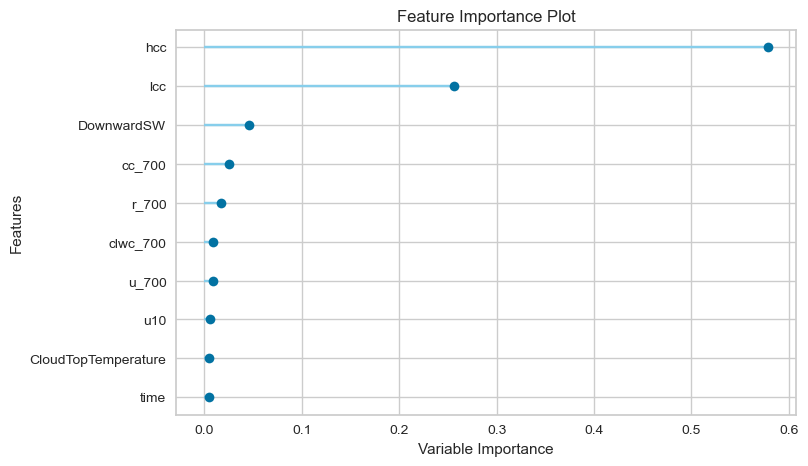

In [15]:
plot_model(best, plot = 'feature')

It is clear that the cloud cover variables (hcc, lcc, cc_700) are the best predictors of the total cloud cover, which is obvious because they are components of the total. However, if we remove these from our training data, how does that change the performance of the model and what features become the new best predictors of total cloud cover?

In [17]:
# create a new dataset from the features dataframe, but remove the "cc" variables
features_no_cc = features.drop(['cc_950', 'cc_700','hcc','lcc'], axis=1)
# show the updated features
features_no_cc.columns

Index(['time', 'r_950', 'r_700', 'clwc_950', 'clwc_700', 't_950', 't_700',
       'u_950', 'u_700', 'v_950', 'v_700', 'w_950', 'w_700', 'u10', 'v10',
       't2m', 'sst', 'slhf', 'sshf', 'tcc', 'CloudOpticalDepth',
       'CloudTopTemperature', 'DownwardSW', 'ReflectedSW', 'TotalPrecipWater'],
      dtype='object')

Perform the same analysis from before.

In [20]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(features_no_cc, test_size=0.2, random_state=42)

In [21]:
from pycaret.regression import *
exp_reg101 = setup(data = train_data, 
                   target = 'tcc',
                   # imputation_type='iterative', 
                   fold_shuffle=True, 
                   session_id=124)

,Description,Value
0,Session id,124
1,Target,tcc
2,Target type,Regression
3,Original data shape,"(79704, 25)"
4,Transformed data shape,"(79704, 25)"
5,Transformed train set shape,"(55792, 25)"
6,Transformed test set shape,"(23912, 25)"
7,Numeric features,24
8,Rows with missing values,95.6%
9,Preprocess,True


In [22]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0785,0.0114,0.1069,0.8842,0.0747,1.0655,9.9370
rf,Random Forest Regressor,0.0901,0.0151,0.1227,0.8474,0.0859,1.4135,27.7140
xgboost,Extreme Gradient Boosting,0.1114,0.0213,0.1461,0.7839,0.1023,1.7281,0.4290
lightgbm,Light Gradient Boosting Machine,0.1363,0.0301,0.1736,0.6946,0.1212,2.4921,0.4750
dt,Decision Tree Regressor,0.1180,0.0347,0.1864,0.6481,0.1298,1.1753,0.6420
gbr,Gradient Boosting Regressor,0.1727,0.0462,0.2149,0.5321,0.1487,3.1788,11.1490
lar,Least Angle Regression,0.2047,0.0619,0.2488,0.3729,0.1718,3.8990,0.0720
ridge,Ridge Regression,0.2054,0.0621,0.2491,0.3714,0.1720,3.9134,0.0630
br,Bayesian Ridge,0.2054,0.0621,0.2491,0.3714,0.1720,3.9170,0.0720
lr,Linear Regression,0.2054,0.0621,0.2491,0.3714,0.1720,3.9132,1.1090


In [23]:
best

ExtraTreesRegressor(n_jobs=-1, random_state=124)

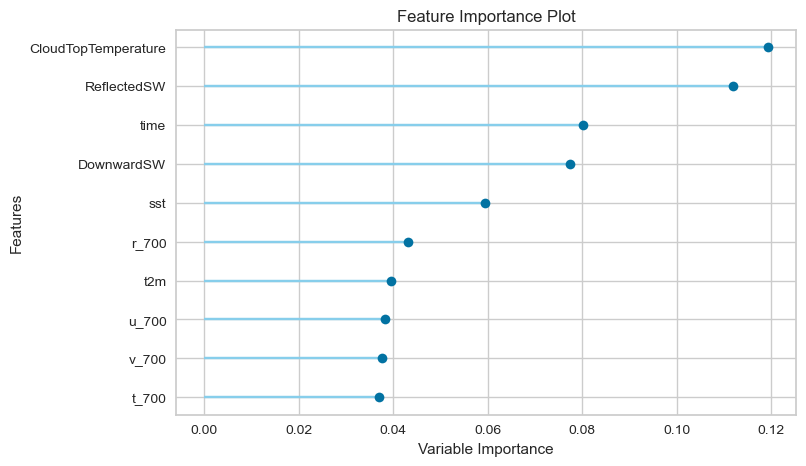

In [24]:
plot_model(best, plot = 'feature')

As seen in the plot above, cloud top temperature and Reflected SW are the best predictors of cloud cover. While we expect reflected SW to be a strong predictor of cloud cover (SW radiation is reflected by clouds), it is somewhat unexpected to see cloud top temperature as a predictor for cloud cover. It may be that the cloud top temperature data is only above 0 or NaN when a cloud is actually present, which can be used as an indicator of cloud cover, but the actual temperature may not dictate the cover of clouds. Additionally, we see that time is a fair predictor of cloud cover, meaning that there is a strong correlation in the data between the date and the total cloud cover. This tells us that the day-to-day cloudiness is being considered by the model, suggesting that we do not have a sufficient number of days in our dataset.